# Details of Drainage Simulations with and without Gravity

In this tutorial we will explain the 'inner workings' of the ``drainage`` algorithm, which can be used to incorporate the effect of gravity.  This algorithm as published in Water Resources Reseach.

In [2]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spim
from edt import edt
from porespy.tools import get_tqdm
tqdm = get_tqdm()

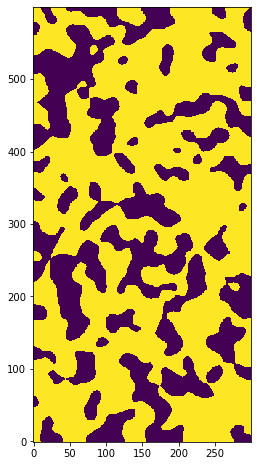

In [3]:
np.random.rand(6)
im = ps.generators.blobs([600, 300], porosity=0.65, blobiness=1.5)
fig, ax = plt.subplots(figsize=[4, 8])
ax.imshow(im, origin='lower', interpolation='none');

The algorithm works by first computing the hypothetical capillary pressure of the largest sphere that can be centered on each voxel. This requires computing the distance transform of the image, which supplies the radius of the largest sphere that can be centered on each voxel, then applying the Washburn equation (or any capillary pressure equation of your choice).  First let's specify some physical properties of the system:

In [4]:
sigma = 0.072
theta = 180
g = 9.81
delta_rho = 1000
voxel_size = 1e-4  # Large voxel size to emphasis the gravity effect|

Then let's find distance tranform:

In [5]:
dt = edt(im)*voxel_size  # convert from voxels to meters

Now we can compute pc:

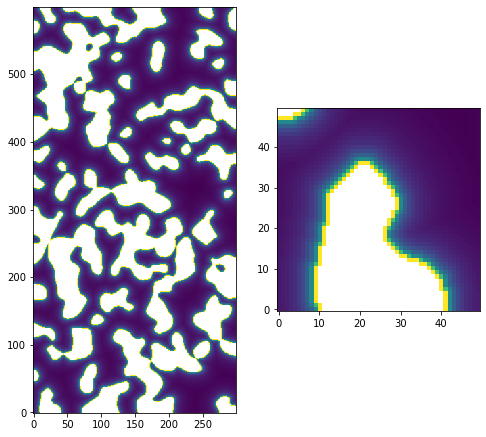

In [6]:
pc = -2*sigma*np.cos(np.deg2rad(theta))/dt
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(pc, origin='lower', interpolation='none')
ax[1].imshow(pc[:50, :50], origin='lower', interpolation='none');

The left shows the full image, while the right shows a subsection.  In this subsection it can be seen that higher values of $P_C$ are found closer to the walls (indicated by the greyscale value).  This is because only very small circles can be draw in those locations, but these are immaterial because as we'll see the larger spheres drawn in the center of the void regions will consume these at much lower capillary pressures.

We need to augment this image before we can proceed, by adding the effect of gravity. The capillary pressure can be altered as:

$$ P_C' = P_C + \Delta\rho g h $$

Which tells us that not only do we need to apply a sufficient capillary pressure to invade a certain region, we also need to overcome the gravity effect.  

Adding the effect of $\rho$ and $g$ is straightforward, but find $h$ will require a bit of work.  In practice this can be done using a combination of ``np.arange`` and ``np.tile``, but this requires a lot of care to get the dimensions and shapes correct.  It is much easier, though slower, to use a distance transform as follows:

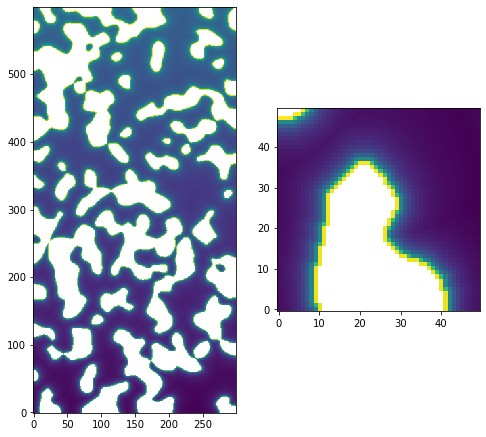

In [7]:
bottom = np.ones_like(im)
bottom[0, :] = False
h = (edt(bottom) + 1)*voxel_size
pc = pc + delta_rho * g * h
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(pc, origin='lower', interpolation='none')
ax[1].imshow(pc[:50, :50], origin='lower', interpolation='none');

Now we can see that the hypothetical capillary pressure has a noticable gradient, indicating that the voxels higher in the image require more capillary pressure to invade. Not only must the invading non-wetting phase overcome the geometrical constraints, but it must also overcome the force of gravity pulling it down.

We are now ready to perform an injection of non-wetting phase from the bottom of the image.  Let's apply a pressure equal to the half of median of the image:

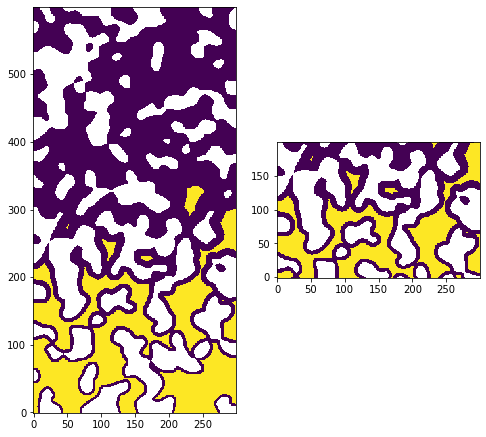

In [8]:
pc_applied = np.median(pc)/2
seeds = pc < pc_applied
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(seeds/im, origin='lower', interpolation='none')
ax[1].imshow((seeds/im)[100:300, ...], origin='lower', interpolation='none');

All the yellow values are void voxels that can *potentially* be penetrated by the applied capillary pressure. Howeve, there is an issue that needs to be addressed.  There are several clusters of seeds that are not connected.  These indicate regions of void space that are (a) large enough to accomodate capillary mensicii of the given size, and (b) low enough that gravity does not prevent the fluid from reaching them.  However, they are not connected to the seeds at the inlet because they are shielded by a tight constriction.  We can remove these seeds using the ``trim_disconnected_voxels`` function in porespy, or manually. Let's do it manually for illustration purposes.  Start by labeling each clusters of seeds:

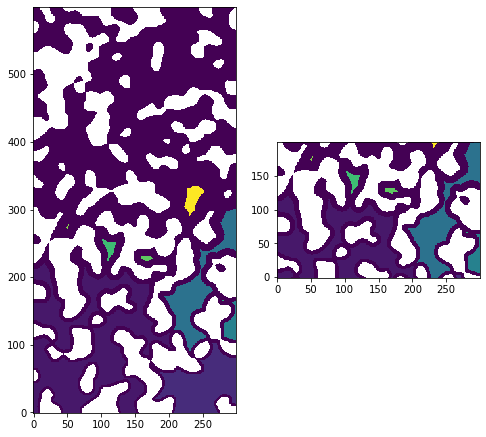

In [9]:
labels = spim.label(seeds)[0]
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(labels/im, origin='lower', interpolation='none')
ax[1].imshow((labels/im)[100:300, ...], origin='lower', interpolation='none');

We can see that any voxels that are not dark blue/purple should be removed.  Or more generally, we can scan the inlet edge of the image for unique values, then enure only those remain:

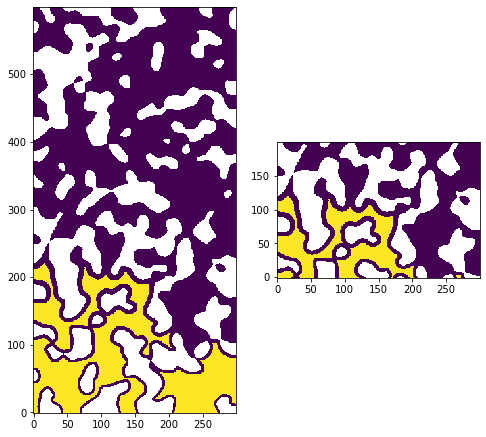

In [10]:
keep = np.unique(labels[0, ...])
keep = keep[keep > 0]  # Remove 0's if any
seeds = np.isin(labels, keep)
fig, ax = plt.subplots(1, 2, figsize=[8, 16])
ax[0].imshow(seeds/im, origin='lower', interpolation='none')
ax[1].imshow((seeds/im)[100:300, ...], origin='lower', interpolation='none');

Now that we've removed these inaccessible seed voxels, we can proceed. To convert this result into a fluid configuration requires inserting spheres at each yellow voxel, the diameter of each sphere taken from the value of the distance transform.  This last step means that we must analyze and process each yellow pixel separately, but this is necessary:

In [11]:
blobs = np.zeros_like(im)
hits = np.where(seeds)
for loc in tqdm(range(len(hits[0]))):
    i, j = hits[0][loc], hits[1][loc]
    r = int(dt[i, j]/voxel_size) # Convert back into voxels
    ps.tools.insert_sphere(im=blobs, c=np.hstack([[i, j]]), r=r, v=True)

  0%|          | 0/23342 [00:00<?, ?it/s]

> Python's native for-loops, like the one above, are quite slow.  There are many ways to speed this up, for instance using 'just in time' compilation provided by the [numba package](https://numba.pydata.org/).  Porespy uses several such optimizations behind the scenes.  The above code snippet is just for illustration and is not recommended for actual use.

Let's visualize both the initial ``seeds`` as well as the added non-wetting phase ``blobs``

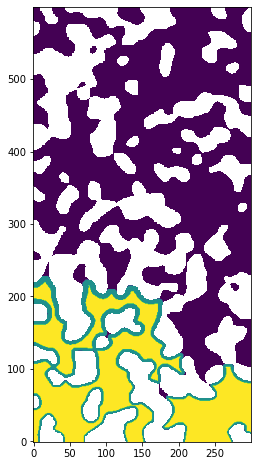

In [12]:
fig, ax = plt.subplots(figsize=[4, 8])
ax.imshow((seeds*1.0 + blobs*1.0)/im, origin='lower');

Above we can see that the fluid front is quite compact, indicating that the gravitational effects have been applied.  Now let's calculate the saturation of the image to generate a point for a capillary pressure curve:

In [13]:
satn = blobs.sum()/im.sum()
print(pc_applied, satn)

369.33544921875 0.29382674087606747


To generate a full capillary pressure curve, or more correct a pseudo-capillary pressure curve since the capillary pressure actually varies with height and we are taking the pressure difference between the top and bottom of the domain, we would need to choose a higher value of ``pc_applied`` and repeat.  

This is obviously laborious, so porespy includes functions for doing all of this for us:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

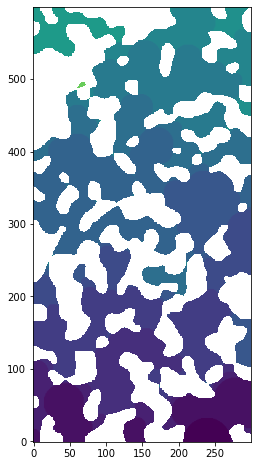

In [14]:
pc1 = ps.simulations.drainage(pc=pc, im=im, voxel_size=voxel_size)
fig, ax = plt.subplots(figsize=[4, 8])
ax.imshow(pc1.im_pc/im, origin='lower');

The above images, show the actual capillary entry pressure for each voxel, including the impact of height and connectivity which we processed manually in the above example.  We can now pass this image to ``pc_curve_from_pressures`` to get the full pseudo-capillary pressure curve:

In [15]:
pc_curve = ps.metrics.pc_curve(pc=pc1.im_pc, im=im)
print(pc_curve)

  0%|          | 0/24 [00:00<?, ?it/s]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
pc                        Array of size (24,)
snwp                      [0.0, 0.01474274546458767, 0.10061605132344818, 0.13299910778773846, 0.2014105450992055, 0.33236181331520587, 0.3967625440795344, 0.4806474911840931, 0.6549177890130433, 0.7441645069465097, 0.8656158388919574, 0.9246802906062794, 0.9397119428984153, 0.9776097208650211, 0.9778051578365977, 0.9780685728852445, 0.9781450482219485, 0.9782215235586523, 0.9790882440412967, 0.9791052385605642, 0.9791562221183668, 0.9791647193780006, 0.9792072056761695, 0.9792072056761695]
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The returned ``pc_curve`` object is a [dataclass](https://realpython.com/python-data-classes/) which is just an object that combines a set of values as attributes.  We can plot this curve by accessing the attributes as follows:

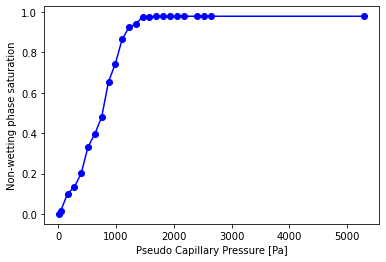

In [16]:
fig, ax = plt.subplots()
ax.plot(pc_curve.pc, pc_curve.snwp, 'b-o')
ax.set_xlabel('Pseudo Capillary Pressure [Pa]')
ax.set_ylabel('Non-wetting phase saturation');

And lastly, just for comparison, let's do the simulation with no gravity:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

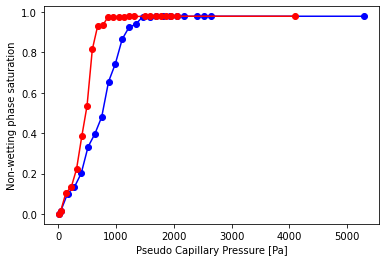

In [17]:
pc2 = ps.simulations.drainage(pc=pc, im=im, g=0, voxel_size=voxel_size)
ax.plot(pc2.pc, pc2.snwp, 'r-o');
fig

Note that the ``pc`` and ``snwp`` values are actually already computed for us and attached to the object that is returned from the ``drainage`` function.  Internally the ``pc_curve`` function is called as above. 